# Example of creating a history plot given a device id for check standard
Written by AWS 05/2016
1. import new file
2. find device id / system_id
3. open history file
4. average values for history* remember error propagation
5. show both on one plot

In [1]:
# imports from standard library
# import of needed libraries
import os
import re
import datetime
import pandas
import sqlite3
import odo
from types import *
from pyMeasure import *
import numpy as np
import matplotlib.pyplot as plt

The module smithplot was not found,please put it on the python path


In [2]:
# Data sources, to be replaced as project_files in Django
TWO_PORT_NR_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Two_Port_NR_Check_Standard.csv"
COMBINED_ONE_PORT_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_One_Port_Check_Standard.csv"
COMBINED_TWO_PORT_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_Two_Port_Check_Standard.csv"
COMBINED_POWER_CHKSTD_CSV=r"C:\Share\Converted_Check_Standard\Combined_Power_Check_Standard.csv"
ONE_PORT_CALREP_CSV=r"C:\Share\Converted_DUT\One_Port_DUT.csv"
TWO_PORT_CALREP_CSV=r"C:\Share\Converted_DUT\Two_Port_DUT.csv"
POWER_3TERM_CALREP_CSV=r"C:\Share\Converted_DUT\Power_3Term_DUT.csv"
POWER_4TERM_CALREP_CSV=r"C:\Share\Converted_DUT\Power_4Term_DUT.csv"

In [3]:
os.chdir(TESTS_DIRECTORY)
test_file='CTN208.A1_011613'
file_model=sparameter_power_type(test_file)

<IPython.core.display.Javascript object>


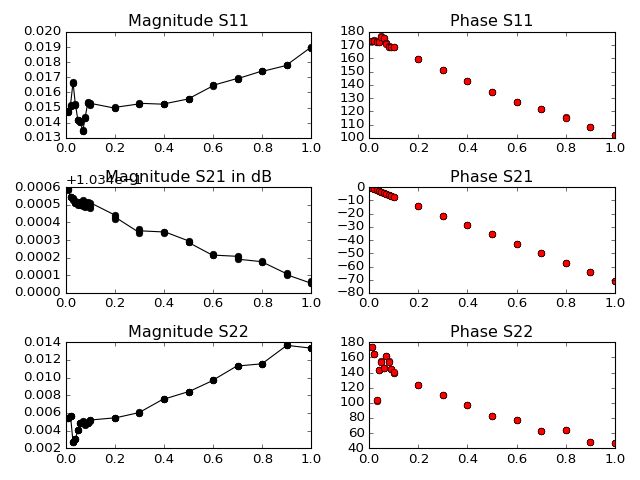

In [4]:
%matplotlib notebook
model=globals()[file_model]
table=model(test_file)
# need to fix the show() method to reflect conversion of S21
table.show()


In [5]:
two_port_history=pandas.read_csv(COMBINED_TWO_PORT_CHKSTD_CSV)

C:\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (10,11,12,16,18,19,20,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
device_id=table.metadata["Device_Id"]
system_id=table.metadata["System_Id"]

In [7]:
device_history=two_port_history[two_port_history["Device_Id"]==device_id]
device_history=device_history[device_history["System_Id"]==system_id]

<IPython.core.display.Javascript object>


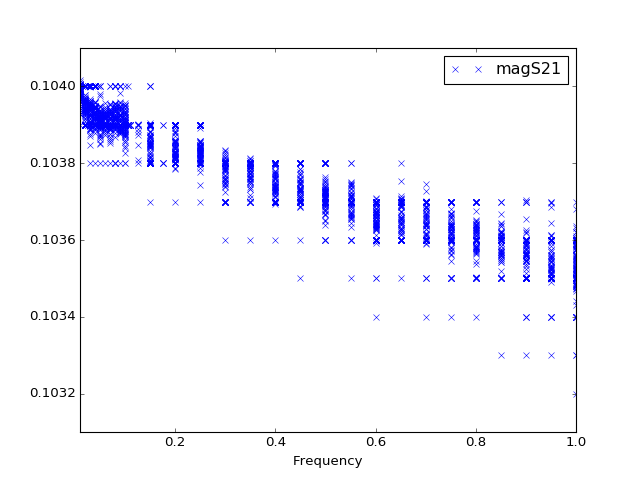

In [8]:
device_history.plot(x="Frequency",y="magS21",style='x')

In [10]:
def two_port_mean(device_id,system_id,history_data_frame):
    """Given a Device_Id and a pandas data frame of the history creates a mean data_frame"""
    device_history=two_port_history[two_port_history["Device_Id"]==device_id]
    device_history=device_history[device_history["System_Id"]==system_id]
    column_names=['Frequency','magS11','argS11','magS21','argS21','magS22','argS22']
    unique_frequency_list=device_history["Frequency"].unique()
    mean_array=[]
    for index,freq in enumerate(unique_frequency_list):
        row=[]
        for column in column_names:
            values=np.mean(device_history[device_history["Frequency"]==unique_frequency_list[index]][column].as_matrix())
            #print values
            mean_value=np.mean(values)
            row.append(mean_value)
        mean_array.append(row)
    mean_frame=pandas.DataFrame(mean_array,columns=column_names)
    return mean_frame
        

In [11]:
mean_frame=two_port_mean(device_id,system_id,two_port_history)

In [17]:
def two_port_comparision_plot(two_port_raw,mean_frame):
    """Creates a comparision plot given a TwoPortRawModel object and a pandas.DataFrame mean frame"""
    fig, axes = plt.subplots(nrows=3, ncols=2)
    measurement_date=two_port_raw.metadata["Measurement_Date"]
    ax0, ax1, ax2, ax3, ax4, ax5 = axes.flat
    ax0.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('magS11'),'k-o',label=measurement_date)
    ax0.plot(mean_frame['Frequency'].tolist(),mean_frame['magS11'].tolist(),'gs',label='Mean')
    ax0.set_title('Magnitude S11')
    ax1.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('argS11'),'ro',label=measurement_date)
    ax1.plot(mean_frame['Frequency'].tolist(),mean_frame['argS11'].tolist(),'gs',label='Mean')
    ax1.set_title('Phase S11')
    ax2.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('magS21'),'k-o',label=measurement_date)
    #ax2.plot(mean_frame['Frequency'].tolist(),mean_frame['magS21'].tolist(),'gs',label='Mean')
    ax2.plot(mean_frame['Frequency'].tolist()
             ,mean_frame['magS21'].tolist(),'gs',label='Mean')
    ax2.set_title('Magnitude S21')
    ax3.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('argS21'),'ro',label=measurement_date)
    ax3.plot(mean_frame['Frequency'].tolist(),mean_frame['argS21'].tolist(),'gs',label='Mean')
    ax3.set_title('Phase S21')
    ax4.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('magS22'),'k-o',label=measurement_date)
    ax4.plot(mean_frame['Frequency'].tolist(),mean_frame['magS22'].tolist(),'gs',label='Mean')
    ax4.set_title('Magnitude S22')
    ax5.plot(two_port_raw.get_column('Frequency'),two_port_raw.get_column('argS22'),'ro',label=measurement_date)
    ax5.plot(mean_frame['Frequency'].tolist(),mean_frame['argS22'].tolist(),'gs',label='Mean')
    ax5.set_title('Phase S22')
    plt.tight_layout()
    plt.show()
    

<IPython.core.display.Javascript object>


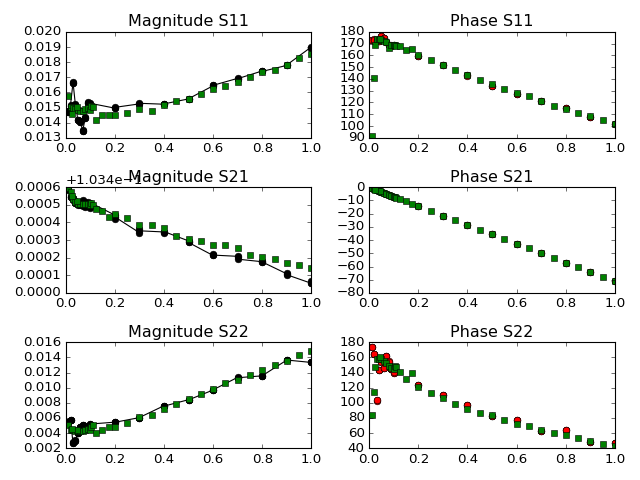

In [18]:
two_port_comparision_plot(table,mean_frame)

device_history["Frequency"].unique()

In [47]:
def two_port_difference(two_port_raw,mean_frame):
    """Creates a difference plot given a two port raw file and a mean plot"""
    difference_list=[]
    for row in two_port_raw.data[:]:
        #print row[0]
        mean_row=mean_frame[abs(mean_frame["Frequency"]-row[0])<abs(.0002)].as_matrix()
        #print mean_row
        mean_row=mean_row[0]
        difference_row=[row[i+2]-mean_row[i] for i in range(1,len(mean_row))]
        difference_row.insert(0,row[0])
        difference_list.append(difference_row)
    return difference_list
        

In [48]:
two_port_difference(table,mean_frame)

[[0.01,
  -0.001030936329588018,
  81.746474906367055,
  -5.6760324360083381e-06,
  0.0045333333333333892,
  0.0003050936329588019,
  89.540630337078653],
 [0.01,
  -0.0010009363295880175,
  81.767474906367042,
  -1.2739369880374052e-05,
  -0.0014666666666666162,
  0.0002950936329588023,
  89.71863033707865],
 [0.01,
  -0.00094093632958801819,
  81.87047490636705,
  -5.0774224639033028e-06,
  -0.0054666666666666197,
  0.0002950936329588023,
  89.363630337078661],
 [0.02,
  5.5992063492063537e-05,
  32.391860714285713,
  -2.9660555038502068e-05,
  -0.0011829365079365495,
  0.0012548809523809518,
  50.351912301587291],
 [0.02,
  7.5992063492062722e-05,
  32.481860714285716,
  -2.8344205794977873e-05,
  0.0008170634920634523,
  0.0012448809523809513,
  50.483912301587296],
 [0.02,
  0.00013599206349206375,
  32.354860714285735,
  -2.6190143801035903e-05,
  -0.005182936507936553,
  0.0012448809523809513,
  50.320912301587285],
 [0.03,
  0.0016715957446808514,
  -1.3432425531914873,
  -6.82

In [49]:
column_names=['Frequency','magS11','argS11','magS21','argS21','magS22','argS22']
diff_data_frame=pandas.DataFrame(two_port_difference(table,mean_frame),columns=column_names)

<IPython.core.display.Javascript object>


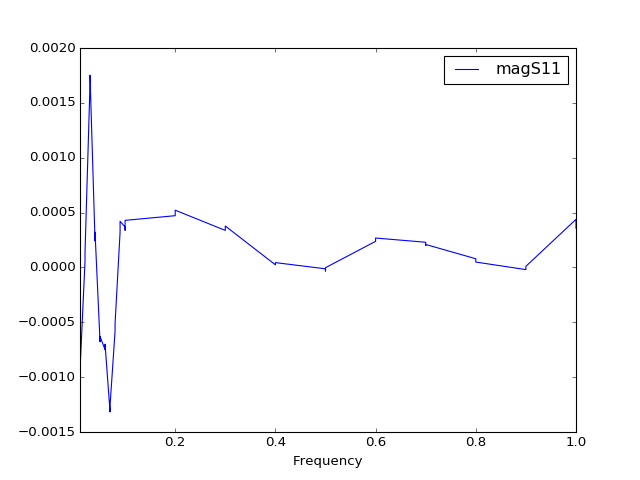

In [54]:
diff_data_frame.plot(x="Frequency",y="magS11")